# План работ по курсовому проекту:

1. построить базовую модель
2. Обернуть в пайплайн
  - sclearn pipline
  - MLFlow с контролем метрик
    * опционально если успею подключить AirFlow
3. Обернут в REST API
  - Flask
  - Django
4. Собрать в контейнер Docker локально
5. Развернуть Docker на AWS

# Задача: построение предсказания качества вина (задача регрессии)

Исходные данные: https://www.kaggle.com/zynicide/wine-reviews

In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# Специальные библиотеки
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV

# Метрики
from sklearn.metrics import precision_score, \
                            accuracy_score, \
                            f1_score, \
                            roc_auc_score,\
                            roc_curve,\
                            auc,\
                            confusion_matrix, \
                            mean_squared_error, \
                            r2_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import pickle

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

## Read dataset

In [2]:
path = './dataset/'
wine_150k = pd.read_csv(path + 'winemag-data_first150k.csv',index_col=0)
wine_130k = pd.read_csv(path + 'winemag-data-130k-v2.csv',index_col=0)
wine = pd.concat([wine_150k,wine_130k],axis=0)
print("Number of rows and columns:",wine.shape)

Number of rows and columns: (280901, 13)


# EDA overview

In [3]:
wine.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title'],
      dtype='object')

In [4]:
wine.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
variety                   object
winery                    object
taster_name               object
taster_twitter_handle     object
title                     object
dtype: object

In [5]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [6]:
wine.describe(include='all',).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,280833,50,US,116901,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,280901,169430,A little bit funky and unsettled when you pop ...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,197701,47239,Reserve,4761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,280901.0,NaN,NaN,NaN,88.146934,3.151528,80.0,86.0,88.0,90.0,100.0
price,258210.0,NaN,NaN,NaN,34.177162,38.611708,4.0,16.0,25.0,40.0,3300.0
province,280833,490,California,80755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,234594,1332,Napa Valley,10689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,111464,18,Central Coast,24122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,280900,756,Pinot Noir,27563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,280901,19186,Williams Selyem,585,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# look at NaN
len(wine) - wine.count()

country                      68
description                   0
designation               83200
points                        0
price                     22691
province                     68
region_1                  46307
region_2                 169437
variety                       1
winery                        0
taster_name              177174
taster_twitter_handle    182143
title                    150930
dtype: int64

Пропусков многовато - взглянем визуально

In [8]:
def show_nan(df_name):
    """Function makes histogram of NaN in dataset
    :param df_name: name of dataset
    """
    nan_df_name = (df_name.isna().sum() / df_name.shape[0]).reset_index()
    nan_df_name.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(x=nan_df_name['feature'], y=nan_df_name['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

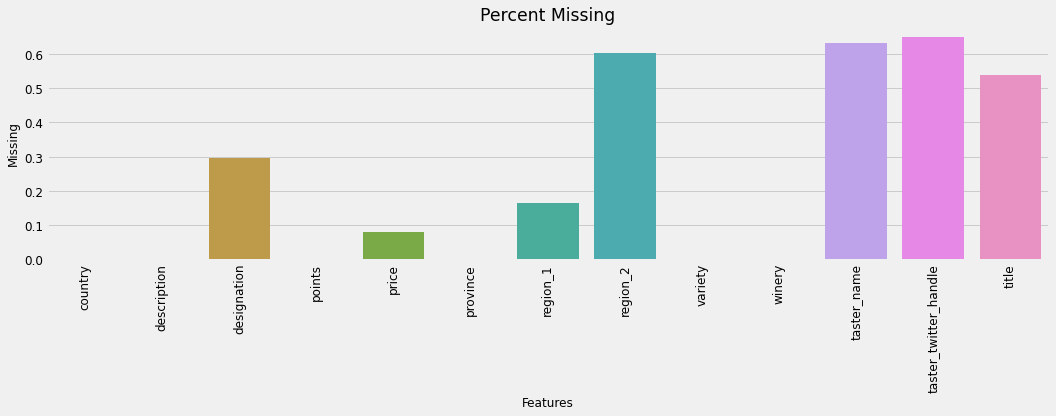

In [9]:
show_nan(wine)

In [10]:
wine.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title'],
      dtype='object')

Большое число пропусков по полям ['region_2', 'taster_name', 'taster_twitter_handle', 'title']. Эти поля придется отбрасывать - заполнение повлечет сильное искажение данных.

In [11]:
features = ['country', 'description', 'designation', 'points', 'price', 'province', 'region_1',
            'variety', 'winery']

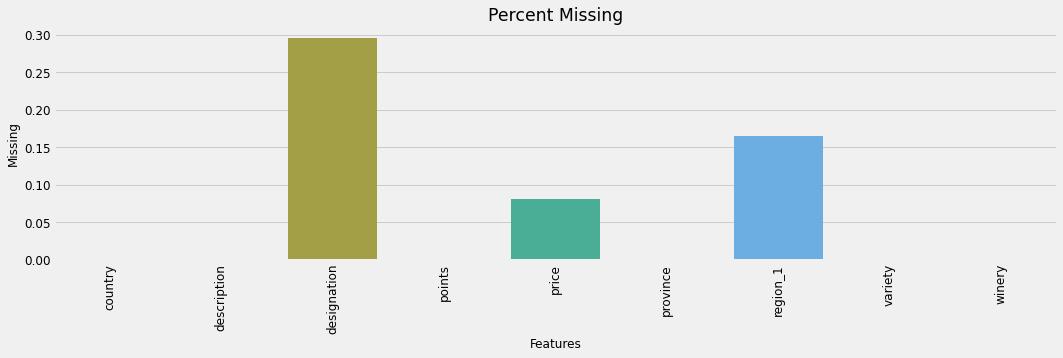

In [12]:
wine = wine[features]
show_nan(wine)

Посмотрим - может часть переменных удасться перевести в категории

In [13]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: country, 	uniques: 51
column: description, 	uniques: 169430
column: designation, 	uniques: 47240
column: province, 	uniques: 491
column: region_1, 	uniques: 1333
column: variety, 	uniques: 757
column: winery, 	uniques: 19186


Посмтрим внимательнее на country - можно перевести в категории - через one_hot_encoding

Number of country list in data: 50


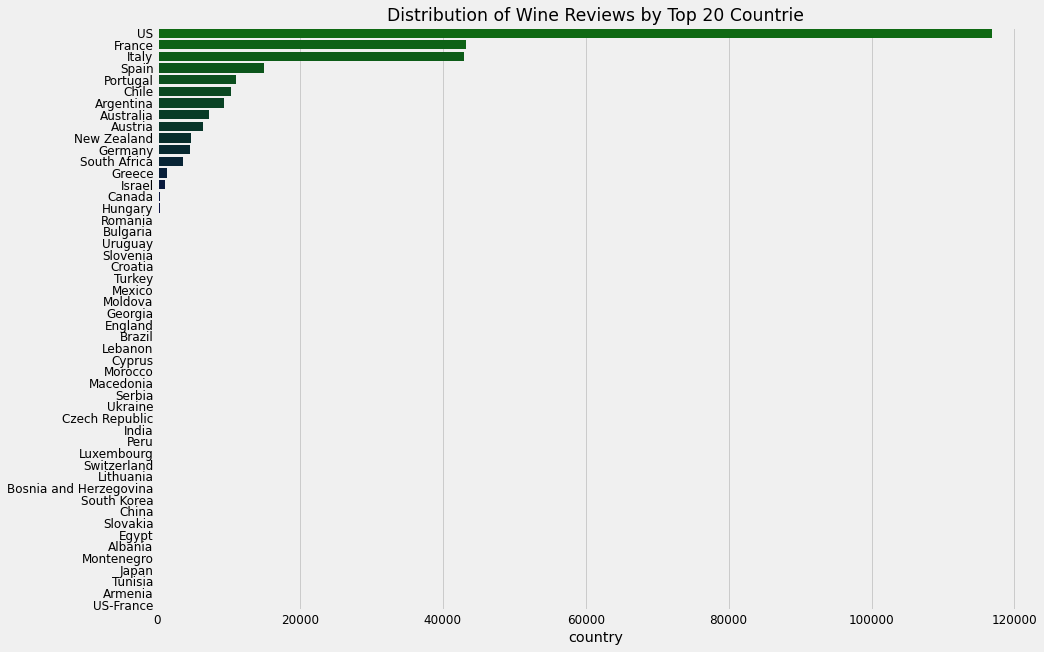

In [14]:
print('Number of country list in data:',wine['country'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['country'].value_counts().to_frame()
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Countrie')
plt.show()

Оставим только значимые позиции

Number of country list in data: 50


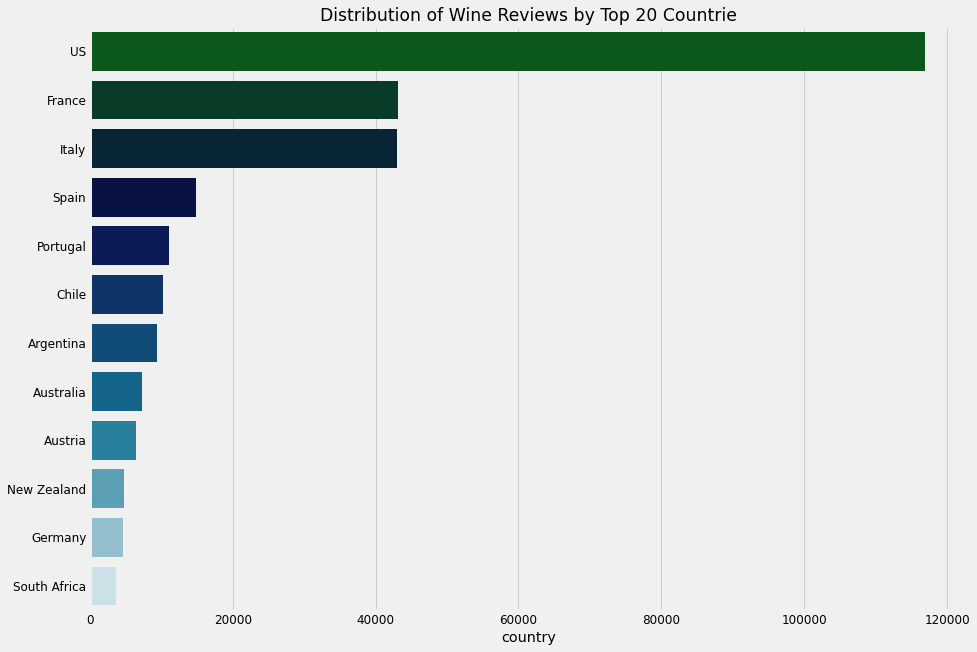

In [15]:
print('Number of country list in data:',wine['country'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['country'].value_counts().to_frame()[:12]
#plt.xscale('log')
sns.barplot(x= cnt['country'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Countrie')
plt.show()

In [16]:
cnt_idx = wine['country'].value_counts().to_frame()[:12].index

In [17]:
print('Потери: {0:.3f} %'.format((wine.shape[0] - wine.loc[wine['country'].isin(list(cnt_idx))].shape[0])/wine.shape[0]*100))


Потери: 1.938 %


Потеряли не так много - оставим только эти основные 12 стран и сделаем one_hot_encoding

In [18]:
wine = wine.loc[wine['country'].isin(list(cnt_idx))]

wine = pd.concat([wine.drop('country', axis=1), 
                          pd.get_dummies(wine['country'], prefix='country')], axis=1)
wine.head()

,description,designation,points,price,province,region_1,variety,winery,country_Argentina,country_Australia,country_Austria,country_Chile,country_France,country_Germany,country_Italy,country_New Zealand,country_Portugal,country_South Africa,country_Spain,country_US
0,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz,0,0,0,0,0,0,0,0,0,0,0,1
1,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez,0,0,0,0,0,0,0,0,0,0,1,0
2,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley,0,0,0,0,0,0,0,0,0,0,0,1
3,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi,0,0,0,0,0,0,0,0,0,0,0,1
4,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude,0,0,0,0,1,0,0,0,0,0,0,0


Посмотрим аналогичное распределение по province

In [19]:
wine.shape

(275458, 20)

In [20]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: description, 	uniques: 166244
column: designation, 	uniques: 45961
column: province, 	uniques: 270
column: region_1, 	uniques: 1321
column: variety, 	uniques: 654
column: winery, 	uniques: 18614


Number of provinces list in data: 270


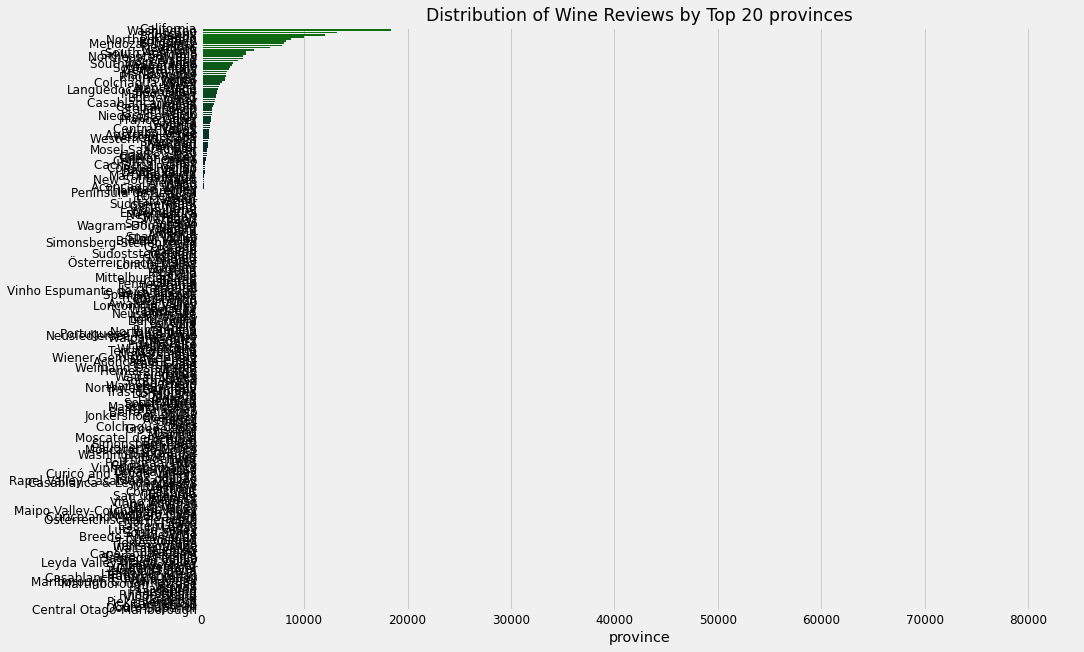

In [21]:
print('Number of provinces list in data:',wine['province'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['province'].value_counts().to_frame()
#plt.xscale('log')
sns.barplot(x= cnt['province'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 provinces')
plt.show()

Оставим только значимые - первые 20 и посмотрим насколько сократится dataset

Number of provinces list in data: 270


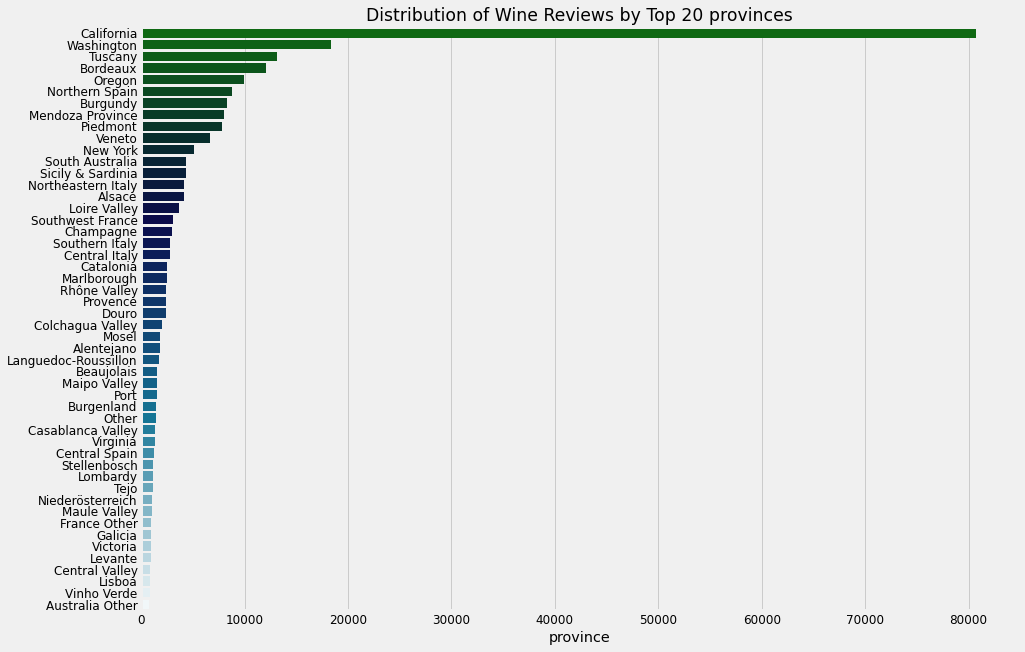

In [22]:
print('Number of provinces list in data:',wine['province'].nunique())
plt.figure(figsize=(14,10))
cnt = wine['province'].value_counts().to_frame()[:50]
#plt.xscale('log')
sns.barplot(x= cnt['province'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Distribution of Wine Reviews by Top 20 provinces')
plt.show()

In [23]:
pr_idx = wine['province'].value_counts().to_frame()[:50].index
print('Потери: {0:.3f} %'.format((wine.shape[0] - wine.loc[wine['province'].isin(list(pr_idx))].shape[0])/wine.shape[0]*100))


Потери: 7.576 %


Оставляем 50 первых регионов

In [24]:
wine = wine.loc[wine['province'].isin(list(pr_idx))]

wine = pd.concat([wine.drop('province', axis=1), 
                          pd.get_dummies(wine['province'], prefix='province')], axis=1)
wine.shape

(254588, 69)

In [25]:
for col in wine.select_dtypes(include='object'):
    print(f'column: {col}, \tuniques: {len(wine[col].unique())}')

column: description, 	uniques: 153588
column: designation, 	uniques: 41881
column: region_1, 	uniques: 1246
column: variety, 	uniques: 603
column: winery, 	uniques: 17460


Сохраним подготовленный dataset

In [26]:
# wine.to_csv('wine_eda.csv')

# Model

In [27]:
wine.columns

Index(['description', 'designation', 'points', 'price', 'region_1', 'variety',
       'winery', 'country_Argentina', 'country_Australia', 'country_Austria',
       'country_Chile', 'country_France', 'country_Germany', 'country_Italy',
       'country_New Zealand', 'country_Portugal', 'country_South Africa',
       'country_Spain', 'country_US', 'province_Alentejano', 'province_Alsace',
       'province_Australia Other', 'province_Beaujolais', 'province_Bordeaux',
       'province_Burgenland', 'province_Burgundy', 'province_California',
       'province_Casablanca Valley', 'province_Catalonia',
       'province_Central Italy', 'province_Central Spain',
       'province_Central Valley', 'province_Champagne',
       'province_Colchagua Valley', 'province_Douro', 'province_France Other',
       'province_Galicia', 'province_Languedoc-Roussillon', 'province_Levante',
       'province_Lisboa', 'province_Loire Valley', 'province_Lombardy',
       'province_Maipo Valley', 'province_Marlborough

Попробуем векторизовать текстовое описание и построить модель на базе случайного леса

In [28]:
wine_short = wine.head(100000)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(wine_short.drop('points', axis=1), 
                                                    wine_short['points'], test_size=0.33, random_state=42)

In [30]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


In [31]:
%%time
classifier = Pipeline([('description_text_selector', FeatureSelector(column='description')), 
                     ('description_text_tfidf', TfidfVectorizer(sublinear_tf=True,
                                                            strip_accents='unicode',
                                                            analyzer='word',
                                                            token_pattern=r'\w{1,}',
                                                            stop_words='english',
                                                            ngram_range=(1, 1),
                                                            max_features=10000)), 
                     ('rfor_clf', ensemble.RandomForestRegressor())])

Wall time: 0 ns


In [32]:
# %%time
# cv_scores = cross_val_score(classifier, X_train, y_train, cv=3)
# cv_score = np.mean(cv_scores)
# print('CV score is {}'.format(cv_score))

In [33]:
# %%time
# #обучим пайплайн на всем тренировочном датасете
# classifier.fit(X_train, y_train)
# y_score = classifier.predict(X_test)

In [34]:
# save
# with open('model_rand_for_reg.pkl','wb') as f:
#     pickle.dump(classifier, f)

In [35]:
# load model
with open('model_rand_for_reg.pkl', 'rb') as f:
    classifier_load = pickle.load(f)

In [36]:
y_score = classifier_load.predict(X_test)

In [37]:
mean_squared_error(y_test, y_score)

3.2289706330726995

In [38]:
r2_score(y_pred=y_score, y_true=y_test)

0.6807745810159924